<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/notebooks/08-NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>NLP - Analisis de Sentimientos con Deep Learning<h1>

En esta notebook haremos una tarea de analisis de sentimientos (clasificacion) en textos de reviews de peliculas usando Deep Learning.

Usaremos varios enfoques involucrando solamente redes MLP y modelos pre-entrenados.

Una de las principales dificultades de este dataset es su tamano y la limpieza del texto.

In [1]:
!gdown 18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf

Downloading...
From: https://drive.google.com/uc?id=18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf
To: /content/IMDB.csv
100% 66.2M/66.2M [00:01<00:00, 38.6MB/s]


In [2]:
import pandas as pd

df = pd.read_csv('IMDB.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Definimos una funcion para limpiar el texto, solo quitamos espacios dobles, etiquetas HTML y caracteres especiales.

In [3]:
import re
import html

def clean_text(text):
    """
    Limpia texto de reviews manteniendo puntuación y stopwords
    """
    if not isinstance(text, str):
        return ""

    # Decodificar entidades HTML
    text = html.unescape(text)

    # Remover etiquetas HTML y <br />
    text = re.sub(r'<[^>]+>', ' ', text)

    # Remover caracteres de control y caracteres especiales problemáticos
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', ' ', text)

    # Normalizar espacios en blanco múltiples
    text = re.sub(r'\s+', ' ', text)

    # Remover espacios al inicio y final
    text = text.strip()

    return text

In [4]:
for text in df['review'].sample(5):
    print(text)
    print(clean_text(text))
    print()

This film contains more action before the opening credits than are in entire Hollywood films of this sort. This film is produced by Tsui Hark and stars Jet Li. This team has brought you many worthy Hong Kong cinema productions, including the Once Upon A Time in China series. The action was fast and furious with amazing wire work. I only saw the wires in two shots. Aside from the action, the story itself was strong and not just used as filler. To find any other action films to rival this you must look for a Hong Kong cinema outlet in your area. They are really worth checking out and usually never disappoint.
This film contains more action before the opening credits than are in entire Hollywood films of this sort. This film is produced by Tsui Hark and stars Jet Li. This team has brought you many worthy Hong Kong cinema productions, including the Once Upon A Time in China series. The action was fast and furious with amazing wire work. I only saw the wires in two shots. Aside from the act

In [5]:
df['review'] = df['review'].apply(clean_text)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
display(df)
y = df['sentiment'].values

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [7]:
docs = list(df['review'].values)

In [8]:
from sklearn.model_selection import train_test_split

train_docs, test_docs, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=462)

print(f'Train size: {len(train_docs)}')
print(f'Test size: {len(test_docs)}')

Train size: 40000
Test size: 10000


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_docs)
X_test = vectorizer.transform(test_docs)

print(X_train.shape)
print(X_test.shape)

(40000, 10000)
(10000, 10000)


# Modelo 1: MLP + TF-IDF

En este primer modelo tomaremos las features TF-IDF del texto y las usaremos como entrada de una red MLP.

Hacemos reduccion de dimensionalidad para facilitar el entrenamiento de la red MLP

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
X_train = pca.fit_transform(X_train.toarray())
X_test = pca.transform(X_test.toarray())

print(X_train.shape)
print(X_test.shape)

(40000, 300)
(10000, 300)


Definimos una arquitectura MLP que recibe las features de TF-IDF

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,649 (108.00 KB)

 Trainable params: 27,649 (108.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min',
                   restore_best_weights=True,
                   verbose=1,
                   patience=3)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6678 - loss: 0.5737 - val_accuracy: 0.8618 - val_loss: 0.3166
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8601 - loss: 0.3374 - val_accuracy: 0.8635 - val_loss: 0.3089
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8736 - loss: 0.3063 - val_accuracy: 0.8705 - val_loss: 0.3058
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8797 - loss: 0.2956 - val_accuracy: 0.8648 - val_loss: 0.3067
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8882 - loss: 0.2839 - val_accuracy: 0.8677 - val_loss: 0.3053
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8887 - loss: 0.2755 - val_accuracy: 0.8698 - val_loss: 0.3082
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8949 - loss: 0.2676 - val_accuracy: 0.8695 - val_loss: 0.3051
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8951 - loss: 0.2627 - val_accuracy: 

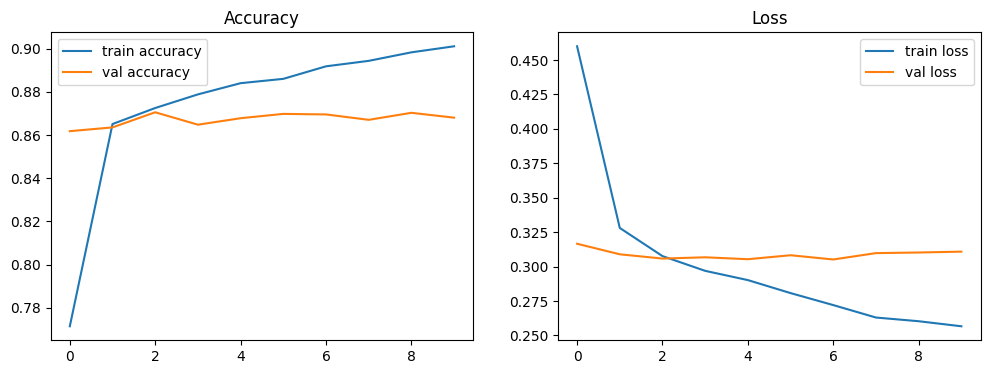

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

In [14]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8752 - loss: 0.2898


[0.292229026556015, 0.8748000264167786]

# Modelo 2: MLP + Embedding Layer + TF-IDF

En este modelo usaremos las features TF-IDF como entrada a una red MLP, usaremos una capa Embedding, la cual asigna un vector denso a cada palabra. Estas representaciones vectoriales pasan a las capas densas ocultas de la red MLP.

Ademas usaremos la capa GlobalAveragePooling1D, la cual toma las representaciones de todas las posiciones de la secuencia (tokens) y calcula el promedio global, reduciendo una matriz de dimensiones (batch_size, sequence_length, features) a (batch_size, features).

Aqui realizamos la conversión de texto a secuencias numéricas para el procesamiento con redes neuronales.

* Primero, el Tokenizer crea un vocabulario con las 10,000 palabras más frecuentes del conjunto de entrenamiento, asignando a cada palabra un índice numérico único.
* Luego convierte cada documento de texto en una secuencia de números, donde cada número representa el índice de una palabra en el vocabulario.
* Finalmente, pad_sequences estandariza todas las secuencias a una longitud fija de 300 elementos, truncando las secuencias más largas y rellenando con ceros las más cortas.

El resultado son matrices numéricas donde cada fila representa un documento y cada columna una posición en la secuencia

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_docs)
train_sequences = tokenizer.texts_to_sequences(train_docs)
X_train = pad_sequences(train_sequences, maxlen=300)

test_sequences = tokenizer.texts_to_sequences(test_docs)
X_test = pad_sequences(test_sequences, maxlen=300)

print(X_train.shape)
print(X_test.shape)

(40000, 300)
(10000, 300)


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Embedding, GlobalAveragePooling1D, BatchNormalization

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Embedding(input_dim=5000, output_dim=32),  # Embedding muy pequeño
    GlobalAveragePooling1D(),

    # MLP minimalista
    Dense(32, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])


# Compilación
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,089 (629.25 KB)

 Trainable params: 161,089 (629.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min',
                   restore_best_weights=True,
                   verbose=1,
                   patience=3)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/10
559/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6065 - loss: 0.6528

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

# Modelo 3: Embeddings Modelo Pre-entrenado

El enfoque de embeddings pre-entrenados con MLP consiste en utilizar modelos de lenguaje entrenados en grandes corpus de texto para convertir documentos en vectores de características numéricas de alta dimensionalidad. Estos embeddings capturan relaciones semánticas y sintácticas del lenguaje que son difíciles de obtener con técnicas tradicionales como bag-of-words o TF-IDF. Una vez obtenidos los embeddings, se alimentan a una red neuronal multicapa que aprende a mapear estas representaciones vectoriales a las clases objetivo.

Este método separa la extracción de características del proceso de clasificación, permitiendo aprovechar el conocimiento lingüístico de modelos entrenados en millones de documentos mientras se mantiene la simplicidad de arquitecturas de clasificación tradicionales.

all-MiniLM-L6-v2 es un modelo de transformador compacto basado en la arquitectura MiniLM que genera embeddings de texto de 384 dimensiones. Fue entrenado mediante destilación de conocimiento a partir de modelos más grandes, manteniendo un rendimiento competitivo con solo 22 millones de parámetros. El modelo utiliza 6 capas de atención y está optimizado para tareas de recuperación de información y similitud semántica, procesando secuencias de hasta 512 tokens y produciendo representaciones vectoriales que capturan el significado contextual del texto de entrada.

⌚ Tarda alrededor de 2 minutos

In [ ]:
from sentence_transformers import SentenceTransformer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtener embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
train_embeddings = model.encode(train_docs)
test_embeddings = model.encode(test_docs)

# Normalizar embeddings (importante para redes neuronales)
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

print(f"Embeddings shape: {train_embeddings_scaled.shape}")

In [ ]:
# MLP con embeddings pre-entrenados
mlp_model = Sequential([
        Input(shape=(train_embeddings_scaled.shape[1],)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

mlp_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

mlp_model.summary()

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Entrenar
history = mlp_model.fit(
    train_embeddings_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
mlp_model.evaluate(test_embeddings_scaled, y_test)

Comparamos con un clasificador de Machine Learning clasico

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(train_embeddings_scaled, y_train)
lr_acc = lr.score(test_embeddings_scaled, y_test)
print(f"Logistic Regression - Test Accuracy: {lr_acc:.4f}")

# Modelo 4: Finetuning con transformers

Finalemente realizaremos fine-tuning de un modelo pre-entrenado DistilBERT para clasificación de sentimientos en este dataset.

El fine-tuning consiste en tomar un modelo que ya aprendió representaciones generales del lenguaje durante su pre-entrenamiento y adaptarlo a una tarea específica mediante entrenamiento adicional con datos etiquetados.

* Las principales ventajas incluyen: requerir menos datos y tiempo de entrenamiento comparado con entrenar desde cero, aprovechar el conocimiento previo del modelo, y obtener mejor rendimiento en tareas específicas.

* Las desventajas son: dependencia de la calidad del modelo base, riesgo de overfitting con datasets pequeños, y la necesidad de recursos computacionales (GPU) para un entrenamiento eficiente.

Utilizaremos DistilBERT por ser una versión compacta de BERT que mantiene el 97% de su rendimiento pero es 40% más pequeño y rápido, ideal para demostraciones prácticas.

In [ ]:
import torch
import numpy as np
import warnings

warnings.filterwarnings("ignore")

Limitaremos los textos con los que probaremos el modelo

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenizar datos
inputs = tokenizer(train_docs, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Crear dataset dict
train_dataset = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'labels': torch.tensor(y_train, dtype=torch.long)
}

In [ ]:
from torch.utils.data import Dataset

class DictDataset(Dataset):
    def __init__(self, data_dict):
        self.data = data_dict
    def __len__(self):
        return len(self.data['labels'])
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

train_dataset = DictDataset(train_dataset)

El entrenamiento dura alrededor de 8 minutos

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./model',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    save_steps=10_000,
    logging_steps=100,
    report_to=[],  # Sin wandb
    run_name="training",
)

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset)

trainer.train()
trainer.save_model("./modelo")

Definimos una funcion para predecir la clase de un texto

In [ ]:
# def predecir(texto):
#     inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     outputs = model(**inputs)
#     return torch.argmax(outputs.logits, dim=-1).item()

In [ ]:
def predecir_lotes(textos, batch_size=8):
    all_predictions = []
    for i in range(0, len(textos), batch_size):
        batch_texts = textos[i:i+batch_size]
        batch_inputs = tokenizer(batch_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

        with torch.no_grad():
            outputs = model(**batch_inputs)
            predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            all_predictions.extend(predictions)

    return np.array(all_predictions)

In [ ]:
# test_docs = test_docs[:500]
# y_test = y_test[:500]

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
predictions = predecir_lotes(test_docs)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.3f}")